# Image postprocessing of time-resolved cavitation

Spectral analysis of cavitating flows from high speed images.
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2020 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 16/07/2021
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia


In [1]:
from pySciCam.pySciCam import ImageSequence # https://github.com/djorlando24/pySciCam
import numpy as np
import glob, sys, os
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
import scipy.integrate, scipy.signal
from joblib import Parallel, delayed
%matplotlib notebook

In [2]:
# Define where images come from.
source_images = "/Users/dduke/Downloads/PHO_75_125_4001_CC_BS.tif"
#source_images = "/Users/dduke/Downloads/PHO_060_250_test5.tif"

SAMPLE_RATE=85000 # fps
SPATIAL_RES=4 # um/pixel

## Load images
Crop and mask as required.

In [3]:
I=ImageSequence(source_images, IO_threads=16, dtype=np.uint16, frames=(0,12000))

Reading /Users/dduke/Downloads/PHO_75_125_4001_CC_BS.tif
	Treating as multipage TIFF - frames specified explicitly
	PythonMagick thinks the bit depth is <class 'numpy.uint16'>
	Reading files into memory...
160 tasks on 16 processors


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:   50.7s
[Parallel(n_jobs=16)]: Done 160 out of 160 | elapsed:  9.8min finished


Read 187.5 MiB in 586.4 sec
	Data in memory:	 (12000, 32, 256)
	Intensity range:	 0 to 65535 	 uint16
	Array size:	187.5 MB


<IPython.core.display.Javascript object>


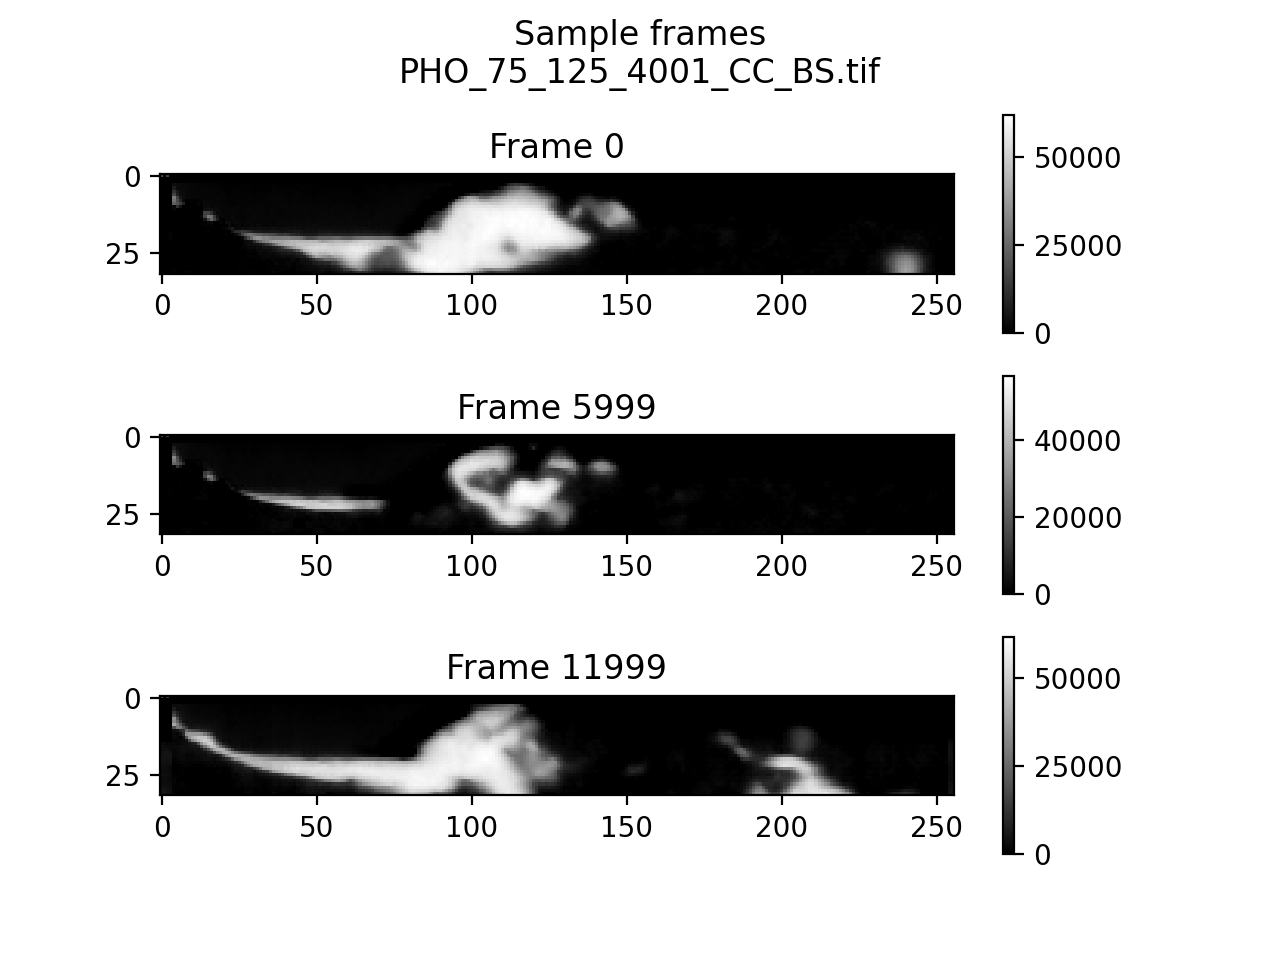

In [4]:
# Show some samples
fig=plt.figure()
plt.suptitle("Sample frames\n"+os.path.basename(source_images))
ax=fig.add_subplot(311)
h=ax.imshow(I.arr[0,...],cmap=plt.cm.gray)
plt.title("Frame 0")
plt.colorbar(h)
ax=fig.add_subplot(312)
h=ax.imshow(I.arr[int(I.N/2)-1,...],cmap=plt.cm.gray)
plt.title("Frame %i" % (int(I.N/2)-1))
plt.colorbar(h)
ax=fig.add_subplot(313)
h=ax.imshow(I.arr[I.N-1,...],cmap=plt.cm.gray)
plt.title("Frame %i" % (I.N-1))
plt.colorbar(h);

## Extract a timeseries for analysis
Spatially average the wall normal fluctuations. Remove the mean from each individua wall-normal timeseries.

<IPython.core.display.Javascript object>


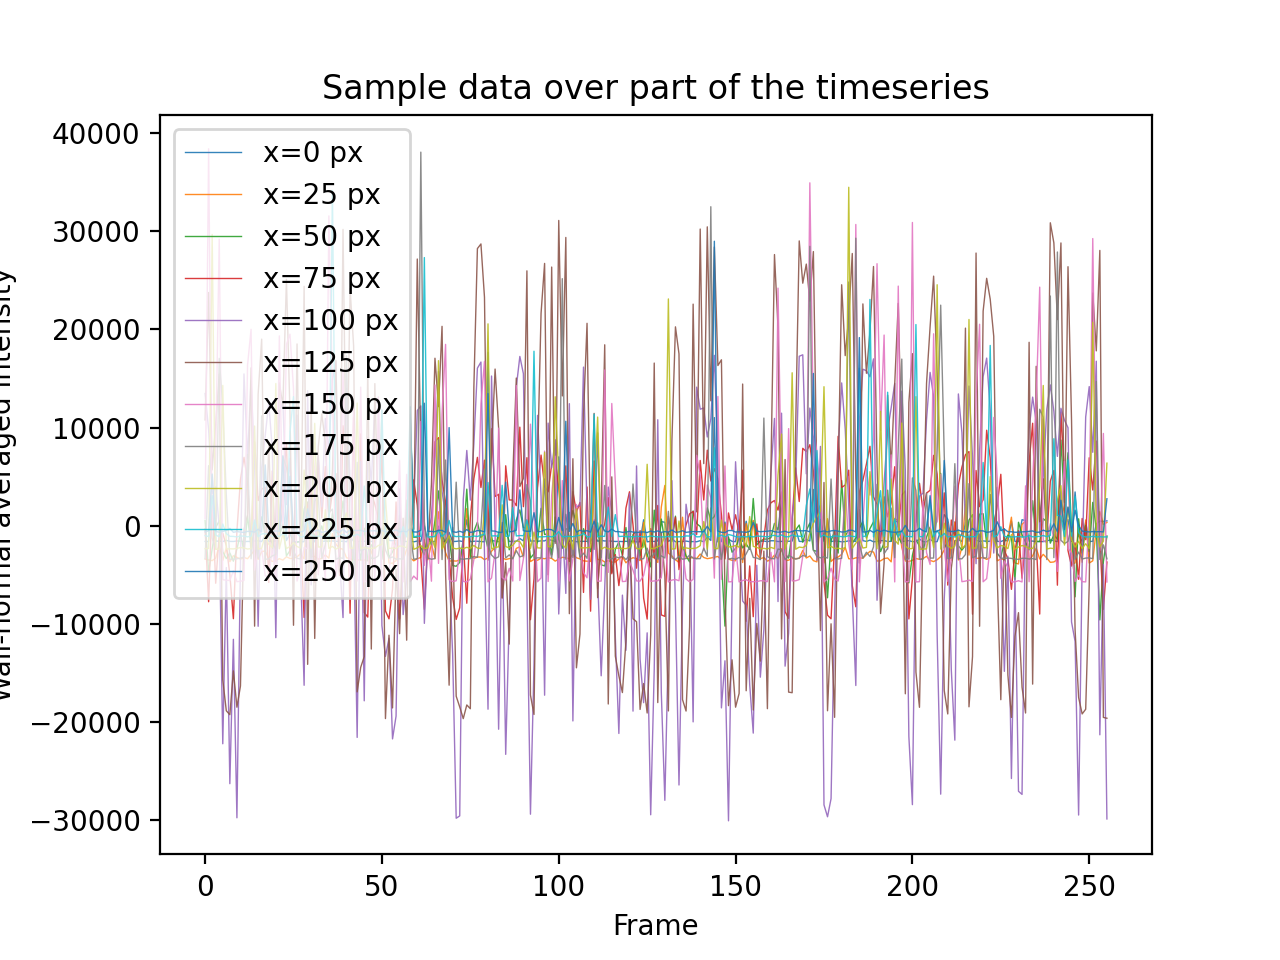

In [5]:
# make float for averaging accurately
Ia = I.arr.astype(np.float32) 
# Average over the wall-normal direction
Ia_spatial_avg = np.nanmean(Ia, axis=1)

# Remove the global mean
#Ia_spatial_avg -= np.nanmean(Ia_spatial_avg) 

# Remove the local wall normal mean
for x in range(Ia_spatial_avg.shape[-1]):
    Ia_spatial_avg[...,x] -= np.nanmean(Ia_spatial_avg[...,x])

# Sample plot - limited time
t0=256
fig=plt.figure()
ax=fig.add_subplot(111)
for x in np.arange(0,Ia_spatial_avg.shape[-1],25):
    ax.plot(Ia_spatial_avg[0:t0,x],lw=.5,alpha=.9,label="x=%i px" % x)
plt.legend()
plt.xlabel('Frame')
plt.ylabel('Wall-normal averaged intensity')
plt.title('Sample data over part of the timeseries');

## Apply Welch's Method to the timeseries
Given a known sampling rate set below.

Ratio samples to N FFT points = 46.875000
Frequency range = 166.015625 - 42500.000000 Hz


<IPython.core.display.Javascript object>


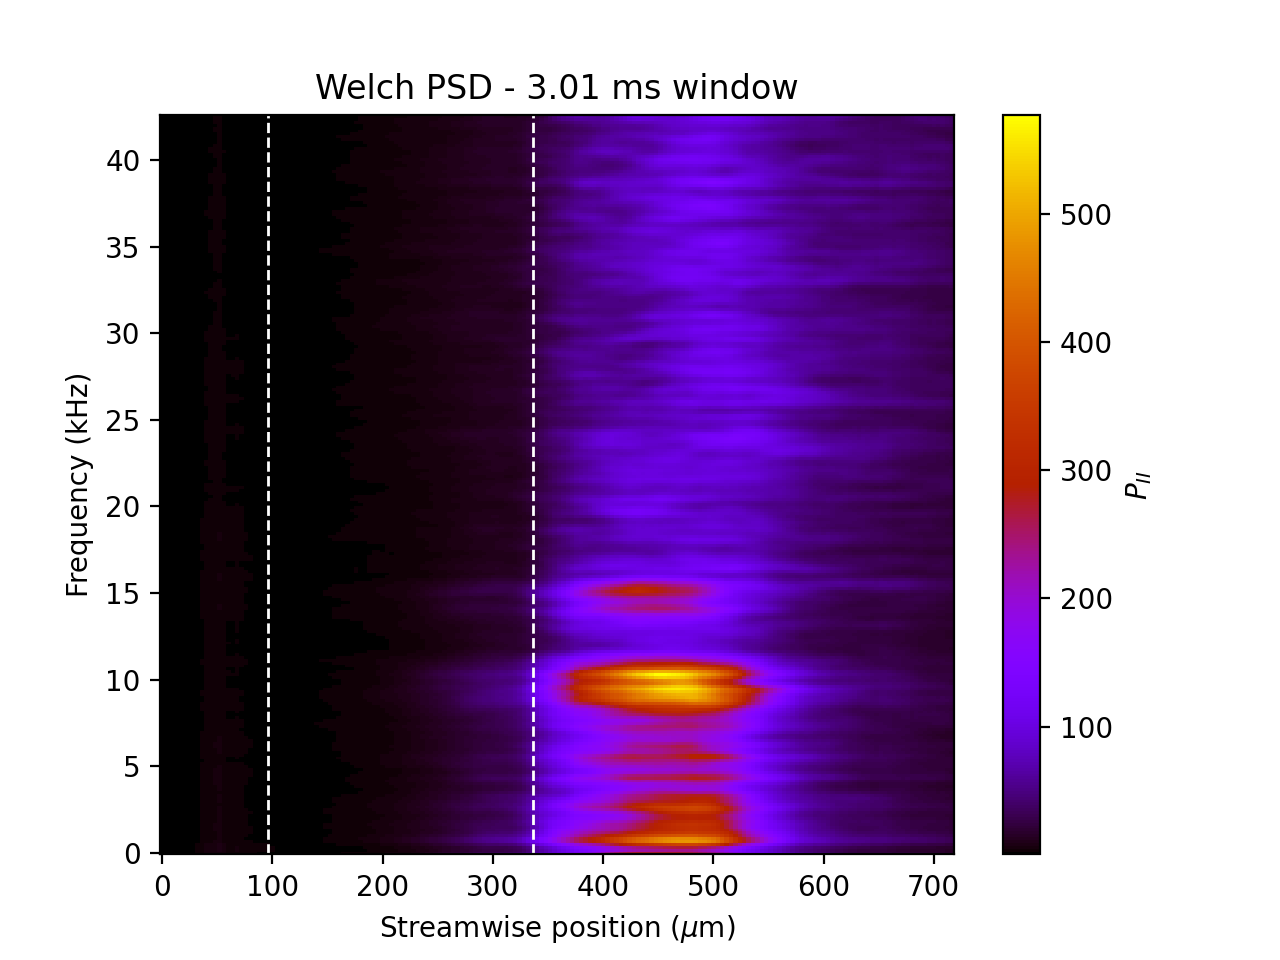

<IPython.core.display.Javascript object>


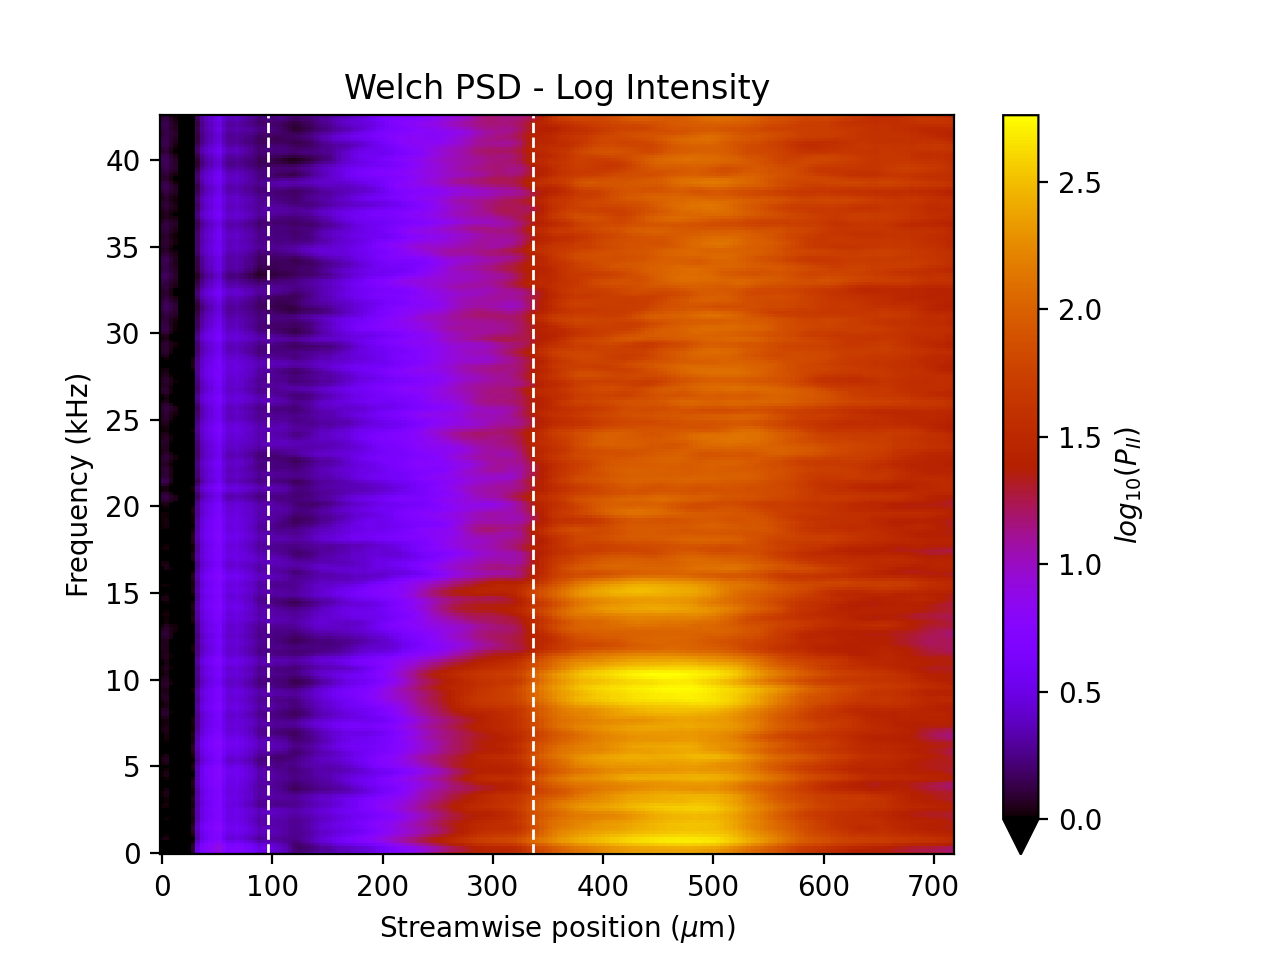

In [31]:
# Apply Welch's method and then make contour plots of the results.
from scipy.signal import welch

nfft=512

print("Ratio samples to N FFT points = %f" % (Ia_spatial_avg.shape[0]/(nfft/2)))

f, Pxx = welch(Ia_spatial_avg[...,0:180], fs=SAMPLE_RATE,\
               window='hann', nperseg=nfft/2, noverlap=nfft/4, nfft=nfft, detrend='constant',\
               return_onesided=True, scaling='density', axis=0, average='mean')

print("Frequency range = %f - %f Hz" % (f[1],f[-1]))

# Make x and f vectors for plotting
xx,ff=np.meshgrid(range(Pxx.shape[1]),f)

# Frequency to kHz
ff/=1e3

# x to micron
xx*=SPATIAL_RES

# Neat trick to remove background fluctuations;
# remove first FFT which is upstream of the feature of interest.
bkgndPxx = np.nanmean(Pxx[:,0:9],axis=1)
for x in range(Pxx.shape[1]):
    Pxx[:,x] /= bkgndPxx

# Make graphs
fig=plt.figure()
ax=fig.add_subplot(111)
zz = Pxx
h=ax.pcolormesh(xx,ff,zz,cmap=plt.cm.gnuplot,shading='nearest')
plt.colorbar(h,label='$P_{II}$')
plt.ylabel('Frequency (kHz)')
plt.xlabel('Streamwise position ($\mu$m)')
plt.title('Welch PSD - %.2f ms window' % (1e3*.5*nfft/SAMPLE_RATE))
plt.axvline(24*SPATIAL_RES,c='w',ls='--',lw=1)
plt.axvline(84*SPATIAL_RES,c='w',ls='--',lw=1);
plt.savefig('Welch1.png')

fig=plt.figure()
ax=fig.add_subplot(111)
zz = Pxx[...]; zz[zz<1e-9]=1e-9
zz = np.log10(zz) # avoid log10 of zero
zz[zz<0]=0 # Minimum value of Pxx is 1.
h=ax.pcolormesh(xx,ff,zz,cmap=plt.cm.gnuplot,shading='nearest')
plt.colorbar(h,label='$log_{10}(P_{II})$',extend='min')
plt.ylabel('Frequency (kHz)')
plt.xlabel('Streamwise position ($\mu$m)')
plt.title('Welch PSD - Log Intensity')
plt.axvline(24*SPATIAL_RES,c='w',ls='--',lw=1)
plt.axvline(84*SPATIAL_RES,c='w',ls='--',lw=1);
plt.savefig('Welch2.png')

<IPython.core.display.Javascript object>


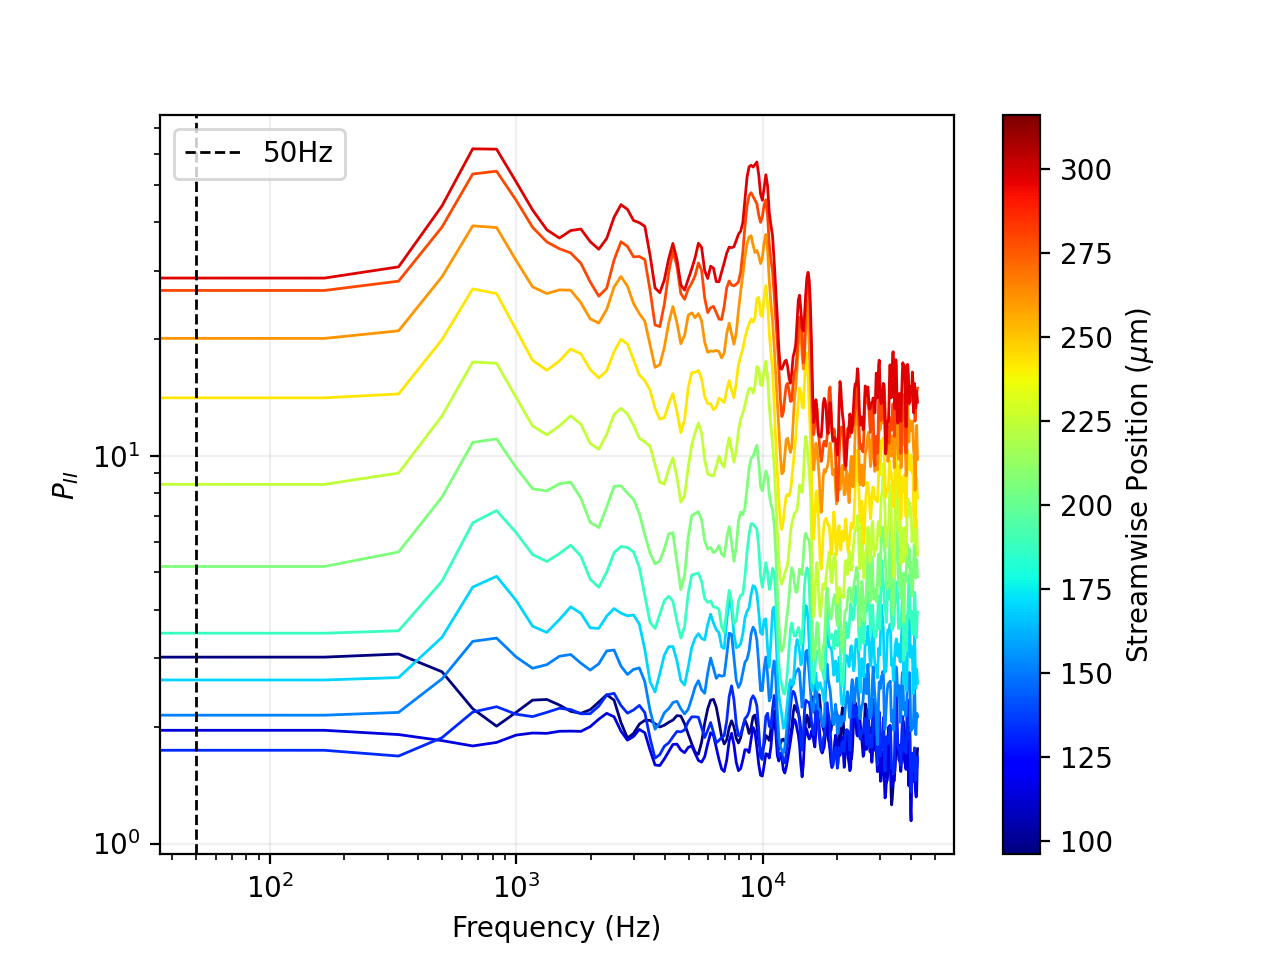

In [32]:
# Plot some selected FFTs

fig=plt.figure()
ax=fig.add_subplot(111)
n=0 # loop counter
xpos = np.arange(24*SPATIAL_RES,84*SPATIAL_RES,20) # positions

# this is required to make the colorbar:
cm = plt.cm.jet#gnuplot
sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(xpos.min(), xpos.max())) 

for x in xpos: 
    #label='x=%i $\mu$m' % (x)
    p=ax.loglog(f, Pxx[:,int(x/SPATIAL_RES)], label=None,\
                c=cm(float(n)/float(len(xpos))), lw=1)
    n+=1

#plt.ylim(10,)
plt.grid(alpha=.2)
plt.axvline(50,ls='--',c='k',lw=1,label='50Hz')
plt.colorbar(sm,label='Streamwise Position ($\mu$m)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('$P_{II}$')
plt.legend(loc=2);
plt.savefig('SpectraOverBump.png')